In [1]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import langid
import re
from summarizer.summarizer import generate_summary

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
#TODO: Explore what are the different steamspy_tags, categories and genres, and deciding which one's to filter the data by

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
steam_data = pd.read_csv(r'C:\Users\olive\gameSinopsisGeneration\steamData\steam.csv', encoding='utf-8')
steam_description_data = pd.read_csv(r'C:\Users\olive\gameSinopsisGeneration\steamData\steam_description_data.csv', encoding='utf-8')
#Change the indexs to make the concatenation easier
steam_data = steam_data.set_index('appid')
steam_description_data = steam_description_data.set_index('steam_appid')

In [3]:
data = pd.concat([steam_data, steam_description_data], axis=1, join='inner')

In [4]:
useless_columns = ['release_date', 'english', 'developer', 'publisher', 'platforms', 
                   'required_age', 'achievements', 'average_playtime', 'median_playtime',
                   'owners', 'price','about_the_game', 'short_description']
data = data.drop(useless_columns, axis=1)

In [5]:
t = []
for tags in data.steamspy_tags.to_list():
    for x in tags.split(';'):        
        t.append(x)
        
tags = Counter(t)
# sorted(tags.items(), key=lambda x: x[1], reverse=True)

In [6]:
filter_tags = ['Sci-fi', 'Strategy', 'Adventure', 'Indie', 'RPG', 'Cyberpunk', 'Fantasy', 'Story Rich', 'Horror']

In [7]:
data = data[data.steamspy_tags.str.contains('Sci-fi', regex=False) | data.steamspy_tags.str.contains('Strategy', regex=False) |
           data.steamspy_tags.str.contains('Adventure', regex=False) | data.steamspy_tags.str.contains('Indie', regex=False) |
           data.steamspy_tags.str.contains('RPG', regex=False) | data.steamspy_tags.str.contains('Cyberpunk', regex=False) |
           data.steamspy_tags.str.contains('Fantasy', regex=False) | data.steamspy_tags.str.contains('Story Rich', regex=False) |
           data.steamspy_tags.str.contains('Horror', regex=False)]
len(data)

22241

In [8]:
data['steamspy_tags'] = data.steamspy_tags.map(lambda x: ";".join([t for t in x.split(';') if t in filter_tags]))

In [ ]:
data['steamspy_tags'] = data.steamspy_tags.map(lambda x: x.replace(' ', '-').lower())
data['steamspy_tags'] = data.steamspy_tags.map(lambda x: x.replace(';', ' ').lower())

In [ ]:
word_len = []
for i in data.detailed_description:
    word_len.append(len(i.split()))

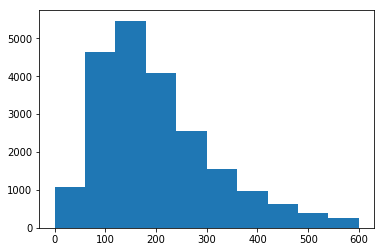

In [ ]:
plt.hist(word_len, bins=10, range=(0,600))
plt.show()

In [ ]:
not_too_large = []
for word in word_len:
    not_too_large.append(word <= 250)

In [ ]:
prepared_data = data[not_too_large]

In [ ]:
# prepared_data['genres'] = prepared_data.genres.map(lambda x: " ".join([genre if genre in filter_tags else '' for genre in x.split(';')]))

In [ ]:
prepared_data.detailed_description = prepared_data.detailed_description.map(lambda x: BeautifulSoup(x, 'html.parser').get_text())

C:\Users\olive\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [ ]:
prepared_data = prepared_data[prepared_data.detailed_description.map(lambda x: langid.classify(x)[0] == 'en' )]

In [ ]:
prepared_data.detailed_description = prepared_data.detailed_description.map(lambda x: re.sub(r'[\t\r]', '', x))

In [ ]:
prepared_data.detailed_description = prepared_data.detailed_description.map(lambda x: generate_summary(x))

C:\Users\olive\Anaconda3\lib\site-packages\nltk\cluster\util.py:133: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [ ]:
prepared_data = prepared_data[prepared_data.steamspy_tags != ""]

In [55]:
prepared_data['steamspy_tags'].to_csv('gpt2_generate.csv', index = False, header=False)

In [56]:
output_data = prepared_data['steamspy_tags'] + " [SEP] " + prepared_data['detailed_description']

In [57]:
output_data.to_csv('gpt2_finetune.csv', index=False, encoding='utf-8', header=False)

In [58]:
genr = data['genres'].tolist()

In [26]:
for g in genr:
    x = g.split(";")
    genr.remove(g)
    genr = genr + x

In [59]:
reals = prepared_data[['steamspy_tags', 'detailed_description']].iloc[:2000] 

In [60]:
reals['real'] = 1
reals.columns = ['tag', 'synopsis', 'real']

In [61]:
reals.to_csv("bert_gan_real.csv", index=False, encoding='utf-8')

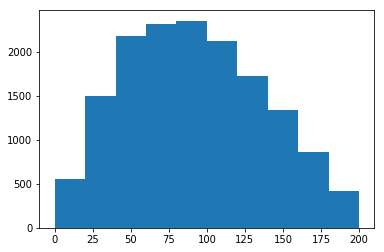

In [62]:
word_len = []
for i in prepared_data.detailed_description:
    word_len.append(len(i.split()))
    
plt.hist(word_len, bins=10, range=(0,200))
plt.show()